In [1]:
import pyprob
from pyprob import Model, InferenceEngine
from pyprob.distributions import Normal

import torch
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Define model

First, we define the model as a probabilistic program inheriting from `pyprob.Model`. Models inherit from `torch.nn.Module` and can be potentially trained with gradient-based optimization (not covered in this example).

In similar spirit to the `torch.nn.Module`, we implement a class constructor called `__init__` and a method called `forward` that represents a single execution of the model's stochastic generative process. In other words, the `forward` method implements a joint distribution over latent and observed variables, which can be used in various ways. During forward sampling from the model, `forward` represents the model prior; during inference, `forward` is used by one of the available probabilistic inference engines to construct a posterior distribution given some observed variables. 

It is expected that `forward` has an argument called `observation` with which any observed variables are supplied. In addition to this, the `forward` method can have any number and type of other arguments as needed.

In [2]:
# Probabilistic program example adapted from
# http://www.robots.ox.ac.uk/~fwood/assets/pdf/Wood-AISTATS-2014.pdf
class GaussianWithUnknownMean(Model):
    def __init__(self, prior_mean=1, prior_stddev=math.sqrt(5), likelihood_stddev=math.sqrt(2)):
        self.prior_mean = prior_mean
        self.prior_stddev = prior_stddev
        self.likelihood_stddev = likelihood_stddev
        super().__init__('Gaussian with unknown mean')

    def forward(self, observation=[]):
        mu = pyprob.sample(Normal(self.prior_mean, self.prior_stddev))
        likelihood = Normal(mu, self.likelihood_stddev)
        for o in observation:
            pyprob.observe(likelihood, o)
        return mu
    
model = GaussianWithUnknownMean()

# Correct analytical posterior to act as ground truth for comparison
def correct_posterior(x):
    p = Normal(7.25, math.sqrt(1/1.2))
    return math.exp(p.log_prob(x))

# The prior

We inspect the prior distribution to see if it behaves in the way we intended. First we construct an `Empirical` distribution with forward samples from the model. 

Note: Any arguments, besides `num_traces`, given to `prior_distribution` will be forwarded to the model's `forward` function.

In [3]:
prior_dist = model.prior_distribution(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 10,110.39       


This gives us an empirical distribution constructed using 1000 sample traces of model execution. We can `sample` from this `Empirical` distribution.

In [4]:
print(prior_dist.sample())

tensor([ 1.7722])


We can plot a histogram of samples from this Empirical distribution.

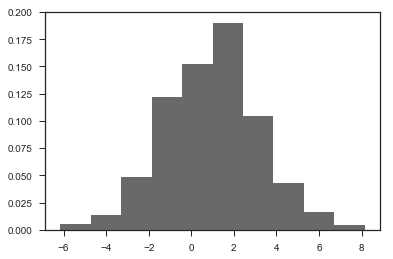

In [6]:
n, bins, patches = plt.hist([float(prior_dist.sample()) for i in range(1000)], density=1, alpha=0.75)

# Posterior inference with lightweight Metropolis Hastings

For a given set of observations, we get an empirical posterior distribution using a lightweight Metropolis Hastings sampler.
See:
- Wingate, D., Stuhlmüller, A. and Goodman, N., 2011, June. Lightweight implementations of probabilistic programming languages via transformational compilation. In Proceedings of the Fourteenth International Conference on Artificial Intelligence and Statistics (pp. 770-778).

In [7]:
posterior_dist = model.posterior_distribution(num_traces=10000, 
                                              observation=[8,9], 
                                              inference_engine=InferenceEngine.LIGHTWEIGHT_METROPOLIS_HASTINGS)

Time spent  | Time remain.| Progress             | Trace       | Accepted|Smp reuse| Traces/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 10000/10000 |   1.24% |   0.00% | 3,288.14       


The following shows the sampled posterior with the correct posterior (orange curve).

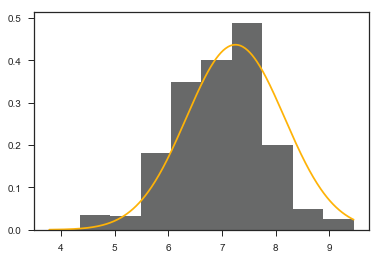

In [8]:
n, bins, patches = plt.hist([float(posterior_dist.sample()) for i in range(1000)], density=1, alpha=0.75)
x = np.linspace(posterior_dist.min,posterior_dist.max,400)
plt.plot(x, np.vectorize(correct_posterior)(x))
plt.show()

# Posterior inference with importance sampling

For a given set of observations, we can get an empirical posterior distribution using importance sampling.

In [9]:
posterior_dist = model.posterior_distribution(num_traces=5000, 
                                              observation=[8,9],
                                              inference_engine=InferenceEngine.IMPORTANCE_SAMPLING)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 5000/5000 | 3,249.89       


Regular importance sampling uses proposals from the prior distribution. We can see this by plotting the histogram of the posterior distribution without using the importance weights. As expected, this is the same with the prior distribution.

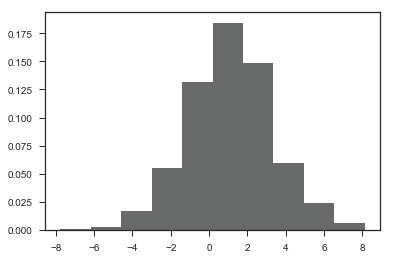

In [10]:
posterior_dist_unweighted = posterior_dist.unweighted()
n, bins, patches = plt.hist([float(posterior_dist_unweighted.sample()) for i in range(1000)], density=1, alpha=0.75)

When we do use the weights, we end up with the correct posterior distribution. The following shows the sampled posterior with the correct posterior (orange curve).

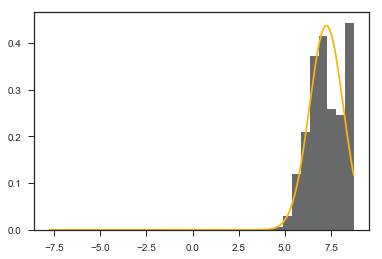

In [11]:
n, bins, patches = plt.hist([float(posterior_dist.sample()) for i in range(1000)], density=1, alpha=0.75)
x = np.linspace(posterior_dist.min,posterior_dist.max,400)
plt.plot(x, np.vectorize(correct_posterior)(x))
plt.show()

In practice, it is advised to use methods of the `Empirical` posterior distribution instead of dealing with the weights directly, which ensures that the weights are used in the correct way.

For instance, we can get samples from the correct posterior, compute its mean and standard deviation, and evaluate expectations of a function under the distribution.

In [12]:
print(posterior_dist.sample())

tensor([ 6.7844])


In [13]:
print(posterior_dist.mean)

tensor([ 7.2217])


In [14]:
print(posterior_dist.stddev)

tensor([ 0.9025])


In [15]:
print(posterior_dist.expectation(lambda x: torch.sin(x)))

tensor([ 0.5309])


# Inference compilation

Inference compilation is a technique where a deep neural network is used for parameterizing the proposal distribution in importance sampling (https://arxiv.org/abs/1610.09900). This neural network, which is also called an "inference network", is automatically generated and trained with data sampled from the model.

We can learn an inference network for our model.

In [16]:
model.learn_inference_network(observation=[0, 0], num_traces=10000)

Creating new inference network...
New layers for address (A1): 16/forward/mu_Normal_1
New distribution type: Normal
New trainable params: 425,000
Train. time | Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
0d:00:00:16 | 10,048    | +2.12e+00 | +1.43e+00 | +1.53e+00 | 0d:00:00:03 | 726.0                              


We now construct the posterior distribution using samples from inference compilation, using the trained inference network.

A much smaller number of samples are enough because the inference network provides good proposals based on the given observations. We can see that the proposal distribution given by the inference network is doing a job much better than the prior, by plotting the posterior samples without the importance weights, for a selection of observations.

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 500/500 | 859.36       


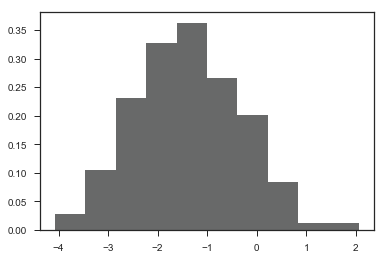

In [17]:
posterior_dist_unweighted = model.posterior_distribution(num_traces=500, 
                                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, 
                                                         observation=[-1,-2]).unweighted()
n, bins, patches = plt.hist([float(posterior_dist_unweighted.sample()) for i in range(1000)], density=1, alpha=0.75)

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 500/500 | 849.62       


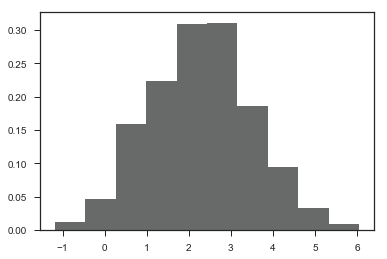

In [18]:
posterior_dist_unweighted = model.posterior_distribution(num_traces=500, 
                                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, 
                                                         observation=[2,3]).unweighted()
n, bins, patches = plt.hist([float(posterior_dist_unweighted.sample()) for i in range(1000)], density=1, alpha=0.75)

Finally, we plot the posterior for the observations `[8, 9]`, print its mean and standard deviation, and plot the analytical ground truth posterior for comparison.

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 500/500 | 848.91       
Mean: tensor([ 7.3128])
Standard deviation: tensor([ 0.9130])


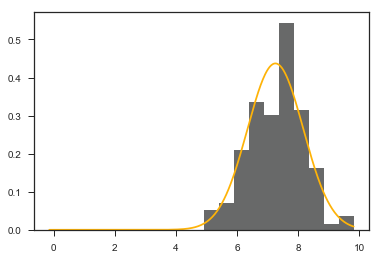

In [19]:
posterior_dist = model.posterior_distribution(num_traces=500, 
                                              inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, 
                                              observation=[8,9])
n, bins, patches = plt.hist([float(posterior_dist.sample()) for i in range(1000)], density=1, alpha=0.75)

x = np.linspace(posterior_dist.min,posterior_dist.max,400)
plt.plot(x, np.vectorize(correct_posterior)(x))

print('Mean:', posterior_dist.mean)
print('Standard deviation:', posterior_dist.stddev)